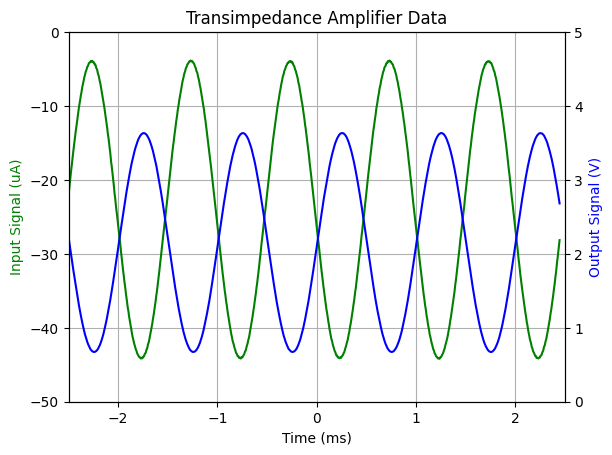

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(f"scope_0.csv", skiprows=1)
t = data["second"].to_numpy()
v_in = data["Volt"].to_numpy()
i_in = v_in / 25000
v_out = data["Volt.1"].to_numpy()

# Use AC RMS values for gain calculation
i_in_dc = np.mean(i_in)
i_in_ac_rms = np.sqrt(np.mean((i_in - i_in_dc)**2))
i_in_pp = np.max(i_in) - np.min(i_in)
v_out_dc = np.mean(v_out)
v_out_ac_rms = np.sqrt(np.mean((v_out - v_out_dc)**2))
v_out_pp = np.max(v_out) - np.min(v_out)
gain = v_out_ac_rms / i_in_ac_rms
gain_db = 20 * np.log10(gain)

freq = 1000
# Find the peaks for input and output signals to determine phase shift
t_max_i_in = t[np.argmax(i_in)]
t_max_v_out = t[np.argmax(v_out)]
phase_delay = t_max_v_out - t_max_i_in
phase_shift_deg = np.remainder(-phase_delay * 360 * freq, 360)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(t * 10**3, i_in * 10**6, 'g-')
ax2.plot(t * 10**3, v_out, 'b-')

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Input Signal (uA)", color='g')
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-50, 0)
ax2.set_ylabel("Output Signal (V)", color='b')
ax2.set_ylim(0, 5)
ax1.grid(which="both", axis="both")
plt.title("Transimpedance Amplifier Data")
plt.show()

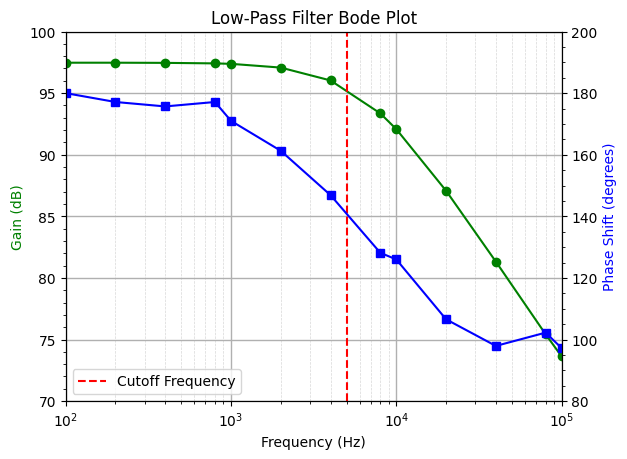

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Frequency sweep, load data from all CSV files
frequencies = np.array([100, 200, 400, 800, 1000, 2000, 4000, 8000, 10000, 20000, 40000, 80000, 100000])
data = [pd.read_csv(f"freq_sweep/scope_{i}.csv", skiprows=1).dropna() for i in range(len(frequencies))]
t = [data[i]["second"].to_numpy() for i in range(len(frequencies))]
v_in = [data[i]["Volt"].to_numpy() for i in range(len(frequencies))]
v_out = [data[i]["Volt.1"].to_numpy() for i in range(len(frequencies))]

# Pad to the same length, and create masks for valid data
max_length = max(len(t[i]) for i in range(len(frequencies)))
t = np.array([np.pad(t[i], (0, max_length - len(t[i])), 'constant', constant_values=np.nan) for i in range(len(frequencies))])
v_in = np.array([np.pad(v_in[i], (0, max_length - len(v_in[i])), 'constant', constant_values=np.nan) for i in range(len(frequencies))])
v_out = np.array([np.pad(v_out[i], (0, max_length - len(v_out[i])), 'constant', constant_values=np.nan) for i in range(len(frequencies))])
mask = ~(np.isnan(t) | np.isnan(v_in) | np.isnan(v_out))
t = np.ma.array(t, mask=~mask)
v_in = np.ma.array(v_in, mask=~mask)
i_in = v_in / 25000
v_out = np.ma.array(v_out, mask=~mask)

# Use AC RMS values for gain calculation
i_in_dc = np.mean(i_in, axis=1)
i_in_ac_rms = np.sqrt(np.mean((i_in - i_in_dc[:, np.newaxis])**2, axis=1))
v_out_dc = np.mean(v_out, axis=1)
v_out_ac_rms = np.sqrt(np.mean((v_out - v_out_dc[:, np.newaxis])**2, axis=1))
gain = v_out_ac_rms / i_in_ac_rms
gain_db = 20 * np.log10(gain)

# Find the peaks for input and output signals to determine phase shift
t_max_i_in = t[np.arange(len(frequencies)), np.argmax(i_in, axis=1)]
t_max_v_out = t[np.arange(len(frequencies)), np.argmax(v_out, axis=1)]
phase_delay = t_max_v_out - t_max_i_in
phase_shift_deg = np.remainder(-phase_delay * 360 * frequencies, 360)

# Plot gain and phase shift on the same chart with dual y-axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(frequencies, gain_db, "g-o")
ax2.plot(frequencies, phase_shift_deg, "b-s")
ax1.set_xscale("log")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_xlim(np.min(frequencies), np.max(frequencies))
ax1.set_ylim(70, 100)
ax2.set_ylim(80, 200)
ax1.set_ylabel("Gain (dB)", color="g")
ax2.set_ylabel("Phase Shift (degrees)", color="b")
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which="major", linestyle="-", linewidth=1, alpha=1)
ax1.grid(which="minor", axis="x", linestyle="--", linewidth=0.5, alpha=0.5)
ax1.set_title("Low-Pass Filter Bode Plot")
ax1.axvline(5000, color="red", linestyle="--", label="Cutoff Frequency")
ax1.legend(loc="lower left")
plt.show()